In [1]:
# con questo secondo esempio faremo ulteriori operazioni oltre alla visualizzazione, in particolare regredding.
# ad esempio vogliamo confrontare, non solo graficamente uno accanto all'altro ma facendo tipo la sottrazione matematica, la mappa delle temperature medie sull'intero periodo da due o più modelli. Dobbiamo fare un'interpolazione spaziale dato che avremo griglie diverse, i dati sono organizzati su griglie diverse, per fare un confronto cella per cella. Questa operazione si chiama re-gridding

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# LAB MODULE 3.
# Climate models
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Topics covered:
# (1) netCDF file format / raster data
# (2) Visualization
# (3) Re-gridding
# (4) Multi-model ensembles

# We will work with datasets from CMIP6 archive; in the examples I will use the following cases:
#  ts_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc
#  ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc
#  ts_Amon_MIROC6_historical_r1i1p1f1_gn_185001-194912.nc

# You can download them either from the link provided in the slides, 
# or from the shared google drive link (login with your UNIMIB credentials only):
#  https://esgf-node.llnl.gov/search/cmip6/
#  https://drive.google.com/file/d/1ZEtDFYKhS_CEeYFzoe23vpDCIqR61bm5/view?usp=sharing

# Regridding

In [2]:
# Example 2
# Regridding, ci sono diverse strategie.

# Let's assume I want to compare the output of two different model simulations, <<<------------------
# in terms of the spatial faetures of surface temperature.
# However, these two models use different horizontal grids.
# >> I need spatial interpolation to a common grid >> regridding

# https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview

# https://stackoverflow.com/questions/25544110/regridding-regular-netcdf-data
# http://xarray.pydata.org/en/stable/interpolation.html#example

# I will proceed using xarray

In [3]:
# Import libraries

import matplotlib.pyplot as plt
import matplotlib as mpl

import cartopy.crs as ccrs
#from cartopy.util import add_cyclic_point

import xarray as xr
import nc_time_axis

import numpy as np

# Lettura file netCDF

In [4]:
#- Open & explore the netCDF file for model 1; extract model name

modfile1='C:/Users/loren/Desktop/ts_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_185001-201412.nc'

m_variable='./ts_Amon_'
m_case='_historical_r1i1p1f1_gr_185001-201412.nc'
model1=modfile1[len(m_variable):-len(m_case)]

d1 = xr.open_dataset(modfile1)
d1


<xarray.Dataset>
Dimensions:      (lat: 143, lon: 144, time: 1980, axis_nbounds: 2)
Coordinates:
  * lat          (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 87.46 88.73 90.0
  * lon          (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time         (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:...
Dimensions without coordinates: axis_nbounds
Data variables:
    time_bounds  (time, axis_nbounds) datetime64[ns] ...
    ts           (time, lat, lon) float32 ...
Attributes: (12/51)
    Conventions:            CF-1.7 CMIP-6.2
    creation_date:          2018-07-11T07:36:33Z
    tracking_id:            hdl:21.14100/3168f5b1-bf0a-4aec-931f-73c9d0034a45
    description:            CMIP6 historical
    title:                  IPSL-CM6A-LR model output prepared for CMIP6 / CM...
    activity_id:            CMIP
    ...                     ...
    name:                   /ccc/work/cont003/gencmip6/p86caub/IGCM_OUT/IPSLC...
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.IPSL.IPSL-CM...
    variant_label:          r1i1p1f1
    realization_index:      1
    history:                Sat Dec  1 12:17:27 2018: ncatted -O -a realizati...
    NCO:                    "4.6.0"

In [5]:
#- Open & explore the netCDF file for model 2; extract model name

modfile2='C:/Users/loren/Desktop/ts_Amon_ACCESS-ESM1-5_historical_r1i1p1f1_gn_185001-201412.nc'

#m_variable='./ts_Amon_'
#m_case='_historical_r1i1p1f1_gr_185001-201412.nc'
model2=modfile2[len(m_variable):-len(m_case)]

d2 = xr.open_dataset(modfile2)
d2


<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 145, lon: 192)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float64 -90.0 -88.75 -87.5 -86.25 ... 86.25 87.5 88.75 90.0
  * lon        (lon) float64 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    lat_bnds   (lat, bnds) float64 ...
    lon_bnds   (lon, bnds) float64 ...
    ts         (time, lat, lon) float32 ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T03:52:25Z
    ...                     ...
    variable_id:            ts
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/0b38948e-85f7-4726-8f0b-291088a1cbef
    license:                CMIP6 model data produced by CSIRO is licensed un...

# Regidding di tipo LINEARE

In [6]:
# Regridding of the entire dataset: bilinear interpolation

# NOTE: normally, we should go from higher resolution to lower resolution !

# il modello 1 aveva una griglia di 143*144
# il modello 2 aveva una griglia di 145 * 192

# noi gli stiamo dicendo interpola d2 su d1, infatti il dataset interpolato ha uan dimensione di 143 * 144

d2i_lin = d2.interp(lat=d1.lat, lon=d1.lon, method='linear')  # è il tipo (linear) più utilizzato, la griglia è quella dell'altro modello, il secondo modello è stato riportato sulla griglia del primo
d2i_lin

<xarray.Dataset>
Dimensions:    (time: 1980, bnds: 2, lat: 143, lon: 144)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat        (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 1850-01-01 1850-02-01 ... 2015-01-01
    lat_bnds   (lat, bnds) float64 -90.0 -89.38 -89.36 ... 89.36 89.38 90.0
    lon_bnds   (lon, bnds) float64 -0.9375 0.9375 1.562 ... 355.9 356.6 358.4
    ts         (time, lat, lon) float64 243.9 243.9 243.9 ... 246.8 246.8 246.8
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  21915.0
    creation_date:          2019-11-15T03:52:25Z
    ...                     ...
    variable_id:            ts
    variant_label:          r1i1p1f1
    version:                v20191115
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/0b38948e-85f7-4726-8f0b-291088a1cbef
    license:                CMIP6 model data produced by CSIRO is licensed un...

In [7]:
# Regridding of the d2.ts dataArray: bilinear interpolation

# NOTE: By doing this, we lose the "bnds", therefore also the cyclical properties of the longitude.
#       This could result in an empty stripe/column visible when plotting
# Workaround: add a cyclic point before plotting
#   https://scitools.org.uk/cartopy/docs/latest/reference/generated/cartopy.util.add_cyclic_point.html
# See example:
#   https://ncar.github.io/CAM-chem/examples/maps/plot_map_basic_co_cbar_cyclic.html

ts2i_lin = d2.ts.interp(lat=d1.lat, lon=d1.lon, method='linear')  # la funzione interp si può applicare sia sull'oggetto dataset (cella precedente) sia su data array (singolo valore, ad esempio ds.ts). In questo caso però rischiamo di perdere alcune infomrazionni, esempio informazioni sulle bande. Potrebbe comparire uan banda bianca. C'è tuttavia un workaround sopra indicato nei commenti.
ts2i_lin


<xarray.DataArray 'ts' (time: 1980, lat: 143, lon: 144)>
array([[[243.86767578, 243.86767578, 243.86767578, ..., 243.86767578,
         243.86767578, 243.86767578],
        [244.55417503, 244.58708988, 244.582961  , ..., 244.51032666,
         244.53822425, 244.54725762],
        [245.57438016, 245.48565251, 245.37126098, ..., 245.80850734,
         245.74941911, 245.65162295],
        ...,
        [242.55063763, 242.55098133, 242.54823747, ..., 242.57386808,
         242.56089719, 242.55731072],
        [242.12131634, 242.11227556, 242.07770667, ..., 242.113701  ,
         242.12335016, 242.1151097 ],
        [240.80757141, 240.80757141, 240.80757141, ..., 240.80757141,
         240.80757141, 240.80757141]],

       [[230.79760742, 230.79760742, 230.79760742, ..., 230.79760742,
         230.79760742, 230.79760742],
        [233.04334697, 232.98769168, 232.92692178, ..., 233.19480607,
         233.15283034, 233.10383971],
        [234.5500761 , 234.32831012, 234.11115428, ..., 235.12066296,
         234.95255028, 234.76682362],
...
        [251.53908023, 251.52192567, 251.52186828, ..., 251.61497684,
         251.5790847 , 251.56568017],
        [250.82892121, 250.800382  , 250.78186117, ..., 250.97697965,
         250.92337815, 250.88270989],
        [250.61981201, 250.61981201, 250.61981201, ..., 250.61981201,
         250.61981201, 250.61981201]],

       [[247.74688721, 247.74688721, 247.74688721, ..., 247.74688721,
         247.74688721, 247.74688721],
        [249.01133018, 249.00383222, 248.99222628, ..., 248.98846883,
         248.99851653, 249.01538979],
        [250.08802114, 250.07063878, 250.02217801, ..., 250.13572879,
         250.13463288, 250.11340709],
        ...,
        [250.55939422, 250.70894673, 250.82591275, ..., 249.91734484,
         250.154537  , 250.37302472],
        [248.47137152, 248.58641434, 248.68152093, ..., 248.12163787,
         248.22866898, 248.35177827],
        [246.77955627, 246.77955627, 246.77955627, ..., 246.77955627,
         246.77955627, 246.77955627]]])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
Attributes:
    standard_name:  surface_temperature
    long_name:      Surface Temperature
    comment:        Temperature of the lower boundary of the atmosphere
    units:          K
    cell_methods:   area: time: mean
    cell_measures:  area: areacella
    history:        2019-11-15T03:52:23Z altered by CMOR: replaced missing va...

# Regidding di tipo NEAREST

In [8]:
#Regridding of the d2.ts dataArray: nearest neighbour interpolation

# rifaccimao le stesse operazioni sopra però in questo caso usando un metodo diverso

ts2i_near = d2.ts.interp(lat=d1.lat, lon=d1.lon, method='nearest')
#ts2i_near

# Confronto dati dei due metodi di interpolazione

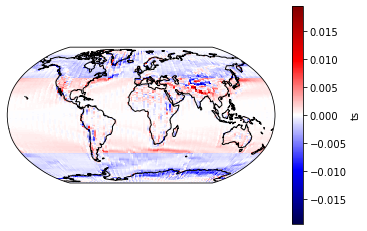

In [9]:
# Compare the bilinear and nearest neighbour methods per valutare le differenze in termini relativi (considerando la temperatura superficiale e non l'intero dataset)

# Calculate the relative difference, considerando la temperatura superficiale (ts)
intdiff = (ts2i_near.mean(axis=0)-ts2i_lin.mean(axis=0))/ts2i_lin.mean(axis=0)    # la differenza relativa, cioè divisa per il valore di uno dei  elementi

#Plot le differenze infatti intdiff.plot
p0 = intdiff.plot(transform=ccrs.PlateCarree(),subplot_kws={'projection': ccrs.Robinson()},
                 cmap='seismic')
p0.axes.coastlines()

# confronto i dati delle due interpolazioni, qual è la differenza che c'è nei valori a seconda della strategia utilizzata
# vediamo dunque che ci sono delle differenze dovute alla scelta dell'interpolatore

In [10]:
intdiff  # ongi cella avrà un valore di differenza relativo associato

<xarray.DataArray 'ts' (lat: 143, lon: 144)>
array([[-1.48191069e-07, -1.48191069e-07, -1.48191069e-07, ...,
        -1.48191069e-07, -1.48191069e-07, -1.48191069e-07],
       [-5.86505210e-05,  2.42370817e-05, -1.20948650e-04, ...,
        -8.08756330e-05,  2.52054670e-06, -1.40461156e-04],
       [-5.51139202e-05,  1.72734757e-04, -2.28627713e-04, ...,
        -1.24960845e-04,  9.70777515e-05, -2.81600852e-04],
       ...,
       [-4.98823931e-05, -1.00162361e-04, -1.65168275e-05, ...,
        -3.39082466e-05, -9.76279297e-05, -2.11239381e-06],
       [-1.78987597e-05, -3.79436238e-05,  5.52536790e-07, ...,
        -1.33402546e-05, -3.01173131e-05,  6.47418515e-06],
       [ 1.88392251e-07,  1.88392251e-07,  1.88392251e-07, ...,
         1.88392251e-07,  1.88392251e-07,  1.88392251e-07]])
Coordinates:
  * lat      (lat) float32 -90.0 -88.73 -87.46 -86.2 ... 86.2 87.46 88.73 90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5

# Confronto modelli

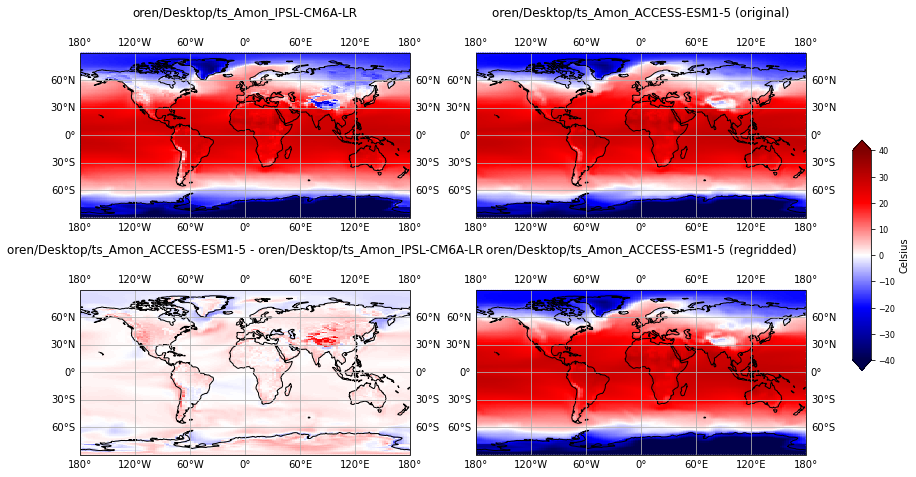

In [21]:
# Now compare the two models, using the entire d2 Dataset regridded with bilinear interpolation

# avendo fatto delle interpolazioni possiamo passare a confrontare i due modelli

# Also, switch from Kelvin to Celsius degrees

ts1_avg=d1.ts.mean("time")-273.15
ts2_avg=d2.ts.mean("time")-273.15
ts2i_avg=d2i_lin.ts.mean("time")-273.15

# Set plot

fig = plt.figure(figsize=(13,8))  # x,y(inches)

subplots = (2,2)
n_panels = subplots[0] * subplots[1]

# I will use the same colormap and scale for all plots, to facilitate comparison.
# Because we will also show the difference, we want this scale to be symmetric about zero

tmax = 40  # gradi centigradi
norm = mpl.colors.Normalize(vmin=-tmax,vmax=tmax) 
cmap = mpl.cm.seismic

# Model 1

ax = fig.add_subplot(subplots[0], subplots[1], 1, projection=ccrs.PlateCarree())
ax.set_title(''.join([model1,'\n']))
ax.set_global()
mm = ax.pcolormesh(d1.lon, d1.lat, ts1_avg,
                   transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )  
ax.coastlines()
ax.gridlines(draw_labels=True)


# Model 2 (orig)

ax = fig.add_subplot(subplots[0], subplots[1], 2, projection=ccrs.PlateCarree())
ax.set_title(''.join([model2,' (original)\n']))
ax.set_global()
mm = ax.pcolormesh(d2.lon, d2.lat, ts2_avg,
                   transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )  
ax.coastlines()
ax.gridlines(draw_labels=True)

# Model 2 (regr)

#ts2i_avg_avg_cyc, lon_cyc = add_cyclic_point(ts2i_avg, coord=d1.lon) 

ax = fig.add_subplot(subplots[0], subplots[1], 4, projection=ccrs.PlateCarree())
ax.set_title(''.join([model2,' (regridded)\n']))
ax.set_global()
mm = ax.pcolormesh(d1.lon, d1.lat, ts2i_avg,
                   transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )  
ax.coastlines()
ax.gridlines(draw_labels=True)


# calcolo differenza
# Model 1 - Model 2 (regr)

tsdiff_avg = (ts2i_avg-ts1_avg)  # absolute difference [2-1]
#tsdiff_avg_cyc, lon_cyc = add_cyclic_point(tsdiff_avg, coord=d1.lon) 

ax = fig.add_subplot(subplots[0], subplots[1], 3, projection=ccrs.PlateCarree())

ax.set_title(''.join([model2,' - ',model1,'\n']))
ax.set_global()
mm = ax.pcolormesh(d1.lon, d1.lat, tsdiff_avg,
                   transform=ccrs.PlateCarree(),cmap=cmap, norm=norm )  
ax.coastlines()
ax.gridlines(draw_labels=True)


#- add colorbar
cbar_ax = fig.add_axes([0.95, 0.30, 0.02, 0.40]) #[left, bottom, width, height]
cbar = fig.colorbar(mm, cax=cbar_ax, extend='both', orientation='vertical')
cbar.set_label('Celsius')
cbar.ax.tick_params(labelsize=8)

plt.show()
plt.close()

# plotto anche la differenza tra i due modelli, mod 1 e mod 2 regriddato sulla griglia del mod 1. Sull'himalya si vedono differenze evidenti.

# in alto a sinistra il primo modello con dati orgin, in alto a destra il secondo modello con dati originali, in basso a destra secondo modello regriddato, in basso a sinistra confronto modello in alto a sinistra e modello in basso a destra

# si può dire che sull'arco temporale di 150 anni il modelli IPSL (in alto a sinistra) tende a simulare delle temperature più elevate sulle terre emerse rispetto al modello (??? dato che facendo al differenza ho colori tendente al rosso, quindi la temperatura nel mod 2 non sarà superiore a quella del mod1 se no andavo sotto zero e avrei avuto colori tendenti all'azzurro)

In [11]:
# IMPORTANT NOTE: 
#
# The xarray.interp() function performs reasonably well in a few examples, however it is not "grid-aware": ci sono infatti delle limitazioni
# - it only has two options operating locally (bilinear, nearest) but lacks conservative regridding
# - it can result in anomalous results and/or yield NANs
#
# Better alternatives exist, not necessarily working on xarray objetcs, using libraries 
#   that can be more problematic to install, though.
# (e.g. esmpy, xesmf, UV-CDAT, iris, nctoolkit, ...)
#